# Detecting rooftop available surface for installing PV modules in aerial images using Machine Learning

In [22]:
import numpy as np
import matplotlib.pyplot  as plt
import torch
from torch.autograd import Variable
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.data import DataLoader, ConcatDataset

from process_data.data_noara_loader import *
from model.unet import *
from loss.loss import *
from process_data.data_loader import *
from hyperparameters.select_param import *
from process_data.import_test import *
from plots import *

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
seed_torch()

# Loading the Data Set
First we load the data set that we will use for training. Each sample is an image with its mask (label). An image is represented as a 3x250x250 array with each of the 3 color chanel being 250x250 pixels. The asssociated mask is a 250x250 array, 

In [8]:
folder_path_image = 'data/image_residencial'
folder_path_mask  = 'data/mask_residencial'
folder_path_noara  = 'data/noARA'

#load dataset
dataset = ConcatDataset([DataLoaderSegmentation(folder_path_image,folder_path_mask),DataLoaderSegmentation(folder_path_noara)])

#split into train, val, test
dataset_size = len(dataset)
train_size = int(0.8*len(dataset))
val_size = int(0.1*len(dataset))
test_size = len(dataset) - train_size - val_size
train_set, val_set, test_set = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])


train_loader = DataLoader(train_set,batch_size=2, shuffle=True ,num_workers=0)
val_loader = DataLoader(val_set,batch_size=2, shuffle=True ,num_workers=0)
test_loader = DataLoader(test_set,batch_size=2, shuffle=True ,num_workers=0)

model = UNet(3,1,False).to(device)


In [89]:
from torch.utils.data import TensorDataset, DataLoader
nimages = 0
mean = 0.
std = 0.
for batch, _ in train_loader:
    # Rearrange batch to be the shape of [B, C, W * H]
    batch = batch.view(batch.size(0), batch.size(1), -1)
    # Update total number of images
    nimages += batch.size(0)
    # Compute mean and std here
    mean += batch.mean(2).sum(0) 
    std += batch.std(2).sum(0)

# Final step
mean /= nimages
std /= nimages

print(mean)
print(std)


tensor([-0.0025, -0.0093, -0.0037])
tensor([1.0032, 1.0053, 1.0127])


# Training Loop

In [ ]:
num_epochs = 200
model = UNet(3,1,False).to(device)
loss_function = torch.nn.BCEWithLogitsLoss(weight=torch.FloatTensor([6]).cuda())
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

trained_model = training_model(train_loader,loss_function,optimizer,model,num_epochs)

In [ ]:
model = trained_model

## Export or Load trained model

In [ ]:
torch.save(model.state_dict(), 'model/trained_model06122020.pt')

In [ ]:
path = 'model/'+input('Name of the model file:')+".pt"
model.load_state_dict(torch.load(path))

# Training with adaptative learning rate

In [9]:
num_epochs = 400
loss_function = torch.nn.BCEWithLogitsLoss(weight=torch.FloatTensor([6]).cuda())
model = UNet(3,1,False).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 100, gamma=0.63, last_epoch=-1, verbose=False)
#scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 10, eta_min=0.01, last_epoch=-1, verbose=True)

history_train_loss, history_val_loss, history_train_iou, history_val_iou = training_model(train_loader,loss_function,optimizer,model,num_epochs,scheduler)


RuntimeError: CUDA out of memory. Tried to allocate 16.00 MiB (GPU 0; 6.00 GiB total capacity; 4.40 GiB already allocated; 15.15 MiB free; 4.52 GiB reserved in total by PyTorch)

In [ ]:
history_train_loss

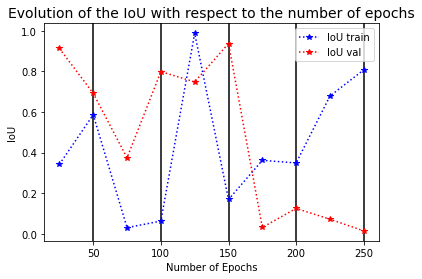

In [23]:
plot_train_val(history_train_loss, history_val_loss, period=25, al_param=50, metric='BCELoss')
plot_train_val(history_train_iou, history_val_iou, period=25, al_param=50, metric='IoU')

# Cross Validation

In [ ]:
loss_function = torch.nn.BCEWithLogitsLoss(pos_weight=torch.FloatTensor([6]).cuda())
n_splits = 2
num_epochs = 10
lr = 0.01

iou_, acc_ = cross_validation(train_dataset=train_set,n_splits, loss_function, num_epochs, lr)

# Find Best Learning Rate

In [ ]:
loss_function = torch.nn.BCEWithLogitsLoss(pos_weight=torch.FloatTensor([6]).cuda())
n_splits = 2
num_epochs = 10
lr = np.logspace(-1,-2,num=5)

best_lr, best_iou = select_hyper_param(train_dataset,n_splits,loss_function,num_epochs,lr_candidates)

# Adaptative Learning
We may do a grid search on the learning rates with cross validation to find the best learning_rate. For now the used metric is iou.

In [ ]:
lr_candidates = np.logspace(-1,-2,num=5)
num_epochs = 5
loss_function = torch.nn.BCEWithLogitsLoss(pos_weight=torch.FloatTensor([6]).cuda())

best_model = UNet(3,1,False).to(device)

best_iou, history_iou = adptative_learning(train_set,val_loader,loss_function,best_model,num_epochs,lr_candidates)


In [ ]:
torch.save(best_model.state_dict(), 'model/best_model06122020.pt')

# Visualization of the model

## Display a image with its mask

In [ ]:
fig = plt.figure()
fig.set_size_inches(12, 7, forward=True)

ax1 = fig.add_subplot(1,3,1)
ax1.title.set_text('Input Image')
ax2 = fig.add_subplot(1,3,2)
ax2.title.set_text('Expected Label')
ax3 = fig.add_subplot(1,3,3)
ax3.title.set_text('Predicted Label')

index_random_sample = int(np.random.random()*len(train_loader.dataset))
(x,y) = train_loader.dataset[239]
ax1.imshow(np.transpose(x.numpy(),(1,2,0)))

ax2.imshow(y)

ypred = torch.squeeze(model.predict(torch.unsqueeze(x,0).cuda())).cpu().detach().numpy()

ax3.imshow(np.around(ypred))
np.around(iou(np.around(ypred),y.numpy()),4),accuracy(np.around(ypred),y.numpy())
acc = np.around(iou(np.around(ypred),y.numpy()),4)
plt.show()
print(acc,accuracy(np.around(ypred),y.numpy()))

## Display an unseen image

In [ ]:
import_and_show(model,'test.png') # Note that 'test.png' should be located in the root of the folder

In [ ]:
test_model(test_loader,model)